# One-dimensional advection equation
v1.64, 20 February 2018, by Brian Fiedler

tweeked Septermber 2023

$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$

This notebook is similiar in style to `DiffusionPDE1D`, except that we investigate modelling of one-dimensional advection:
$$
\pdt{b} = -u \pd{b}{x}
$$
In particular, we study the accuracy and stability of the discrete form of above equation.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output
import time as Time
import math
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.display import Image
from IPython.core.display import HTML
import urllib.request

In [2]:
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer


The symbol $u$ now has the familiar meaning. It is a velocity component in:
$$
\vec{U} = u\Ii + v\Ij  + w\Ik
$$

We model advection of a *conserved* quantity $b$:
$$
\ddt{b} = \pdt{b} + \vec{U} \dt \del b = 0
$$

So being conserved, at a grid point $b$ changes as:
$$
\pdt{b}  = - \vec{U} \dt \del b = -u \pd{b}{x} - v \pd{b}{y} - w \pd{b}{z}
$$

The three terms on the right-hand-side are similar. So, for learning how to model those terms, we consider the first term in isolation.  Also, we do not prognosticate $u(x,t)$, but just specify it:
$$
\pdt{b} = -u \pd{b}{x}
$$
You might think that an obvious, simple choice to use in a discrete model is this
centered difference:
$$
u_n\left( \pd{b}{x} \right)_n = u_n \frac{b_{n+1} - b_{n-1}}{2 \Delta x}
$$

Here is our plan:
 * As we shall see in our explorations, there may options better than the centered difference.
 * When we make our forward time-step, how big can $\Delta t$ be, without the model "blowing up"?  There is a very intuitive limit on $\Delta t$: [Courant–Friedrichs–Lewy condition](http://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition)

In [3]:
# dqdt requires a list of the time derivatives for q, stored 
# in order from present to the past
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")

In [4]:
# Run All Below when changing N, the number of gridpoints
# make the grid
N = 101 # number of x grid points for u. Try 101,201,401. May need to decrease dt for larger N.
xmax = 20 # 0 <= x <= xmax
dx = xmax/(N-1.) # grid width
xu = np.linspace(0,xmax,N) # grid for u
#print(xu)

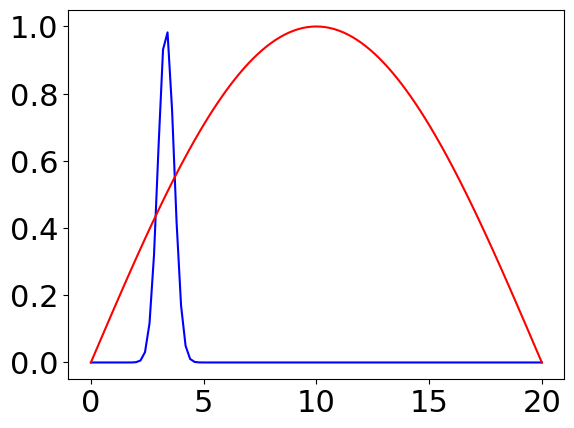

In [5]:
# initialize u, b
xc = xmax/6. # put peak to the left 
#xc = xmax/2. # put peak at center, for oscillating u field
bi = np.exp( -4.*(xu-xc)**2 ) # Gaussian for initial field of b
ui = np.sin(np.pi*xu/xmax) 
#print(bi)
#print(ui)
plt.plot(xu,bi,'b',xu,ui,'r');

In [6]:
startover = True
if 'xsave' not in vars() or startover: bsave={} # for saving b at final time, to compare schemes. dict key will be a label for the expt.
if 'xsave' not in vars() or startover: xsave={} # for saving the grid in various experiments


Run three simulations. In the cell below, set `advord=1`, `advord=2` then `advord=3`. Then run that cell, and the one below it.  Your three results will be stored in `bsave` and `xsave`.  If you need to start over, execute the above cell.

You should find the "third-order" schemes for advection and time-stepping to be mysterious at this point. In a subsequent notebook, these schemes will be derived.

In [7]:
# Run the cells below.  No need to change N
dt = .05 # try dt=.05 with N=101
tstop = 20. # stop when t>tstop
dplot = 1. # time increment between plots
period = 20. # period of oscillation of the u field
#freq=2.*np.pi/period # frequency of the oscillation
freq=0.  #for steady u field
aborder = 3 # Adams-Bashforth order: 1 2 or 3 
advord = 3 # advection order: 1 2 or 3
CFL = dt*1./dx # velocity scale is 1, so this is the CFL number
expt = '%d,%d,%3.2f,%d' % (aborder, advord, CFL, N)
print(expt)

3,3,0.25,101


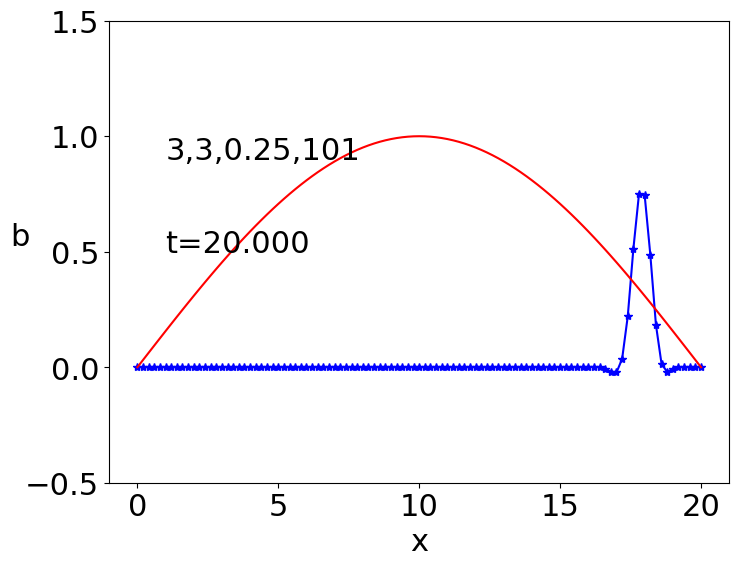

In [8]:
u = ui.copy()
b = bi.copy()
dudt = 0.*u # easy way to make dudt same size as u, with dudt=0
dbdt = 0.*b 
dbdx = 0.*b
dbdta = [0.,0.,0.] # items will be arrays of dbdt, for Adams-Bashforth
nstep = 0
   
t = 0. # initial value for t    
tplot = 0. # time t for next plot

f, ax = plt.subplots(figsize=(8,6))
display(f)

while t < tstop + dt/2.:
    
    nstep+=1
    abnow=min(nstep,aborder)
    
    if tplot-dt/2.< t <tplot+dt/2.: #plot
        Time.sleep(1./20.)
        ax.clear()
        ax.plot(xu,b,'b-*')
        ax.plot(xu,u,'r')
        ax.text(1,.9,expt,fontsize=22)
        ax.text(1,.5,'t={0:5.3f}'.format(t),fontsize=22)
        clear_output(wait=True)
        ax.set_xlabel('x')
        ax.set_ylabel('b',rotation=0)
        ax.set_ylim((-.5,1.5))
        display(f)
        tplot = min(tstop, t+dplot)
        if t<dt/2.: Time.sleep(2.)
        if t>tstop: break
                 
    u = ui*np.cos(freq*t) # oscillating u in time is possible
    
    if advord == 2: # 2nd order centered: uses 1 pt on each side of db/dx location
        dbdx[1:-1] =  (-b[0:-2] + b[2:])/(2*dx) #

    elif advord == 1: #1st order upwind: uses 1 pt at upwind side and 1 pt at db/dx location
        dbdx[1:-1] = np.where( u[1:-1]>0.,
                              -b[0:-2] + b[1:-1]  # use upwind point (which is on the left)
                              ,        - b[1:-1] + b[2:] # use upwind point (which is on the right)
                             )/dx
        
    # The boundary points AND the points adjacent are avoided. Keep b away from boundaries!
    elif advord == 3: #3rd order upwind: uses 2 pts upwind, 1 pt downwind and 1 pt at db/dx location
        dbdx[2:-2] = np.where( u[2:-2]>0., 
                + b[:-4] - 6*b[1:-3] + 3*b[2:-2] + 2*b[3:-1] ,
                            - 2*b[1:-3] - 3*b[2:-2] + 6*b[3:-1] - b[4:] 
                               )/(6*dx)
        
    dbdt[1:-1] = - u[1:-1]*dbdx[1:-1] #advection term
    
# comment-out the above, and uncomment below for AB 1, 2 and 3 
    dbdta = [dbdt.copy()] + dbdta[:-1] # retain latest three time-derivatives 
    b += dt*ab_blend(dbdta,abnow) # Adams-Bashforth blending of time derivatives
    t += dt
    
bsave[expt] = b.copy() # save final value of b for comparison plot 
xsave[expt] = xu.copy() # save for plotting
plt.close() # prevents mysterious second plot from popping up

In [9]:
bsave.keys()

dict_keys(['3,3,0.25,101'])

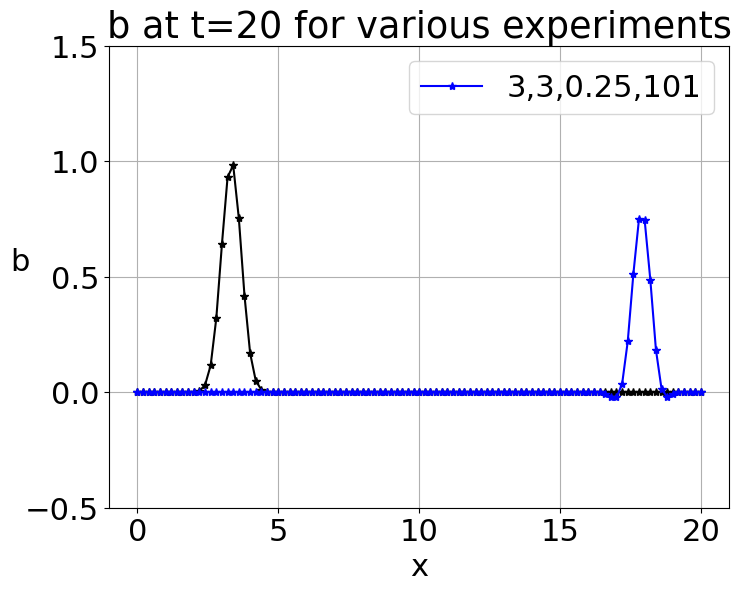

In [10]:
fig, bax = plt.subplots(figsize=(8,6))
bax.plot(xu,bi,'k-*')
style=['b-*','r*-','g*-','c*-']
n=0
for expk in sorted(bsave.keys()):
    sty=style[n%3]
    n += 1
    bax.plot(xsave[expk],bsave[expk],sty,label=expk)
bax.grid()
bax.set_ylabel('b',rotation=0)
bax.set_xlabel('x')
bax.set_ylim( (-.5,1.5))
bax.set_title('b at t=20 for various experiments')
#bax.text(1,-.2,"sample",fontsize=96,alpha=.1)
bax.legend(loc=0)
fig.savefig('saveme.png');

<hr>


# Student tasks

In 2023, the figures the students are seeking are included here.

## 1. advection orders
Make a comparative study  the three advection orders advord=1, advord=2 then advord=3. Rename the saved image to `saveme1.png`, so that this notebook does not overwrite it. Your image should look like: 

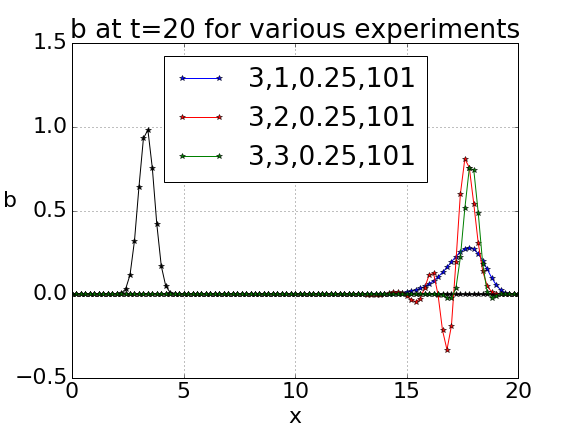

## 2. CFL comparison

Using 3rd order advection and 3rd order AB, adjust `dt` to make CFL number of: 0.125 0.25 0.5, 0.75. Is a CFL number of 0.25 apparently "small enough" for accuracy? Save the image and display it.
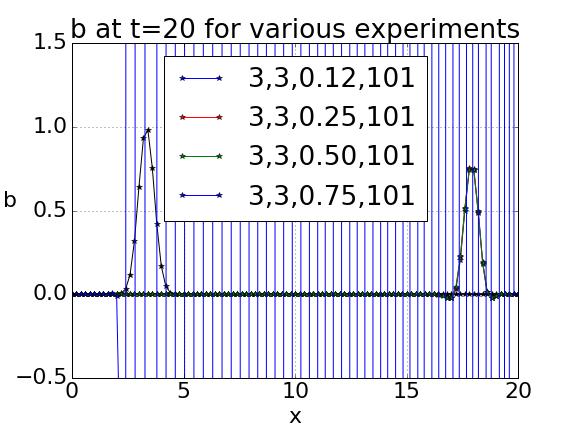


## 3. Adams-Bashforth orders

Make a study of 3rd order upwind advection for the three orders of Adams-Bashforth.  Save the image and display it.


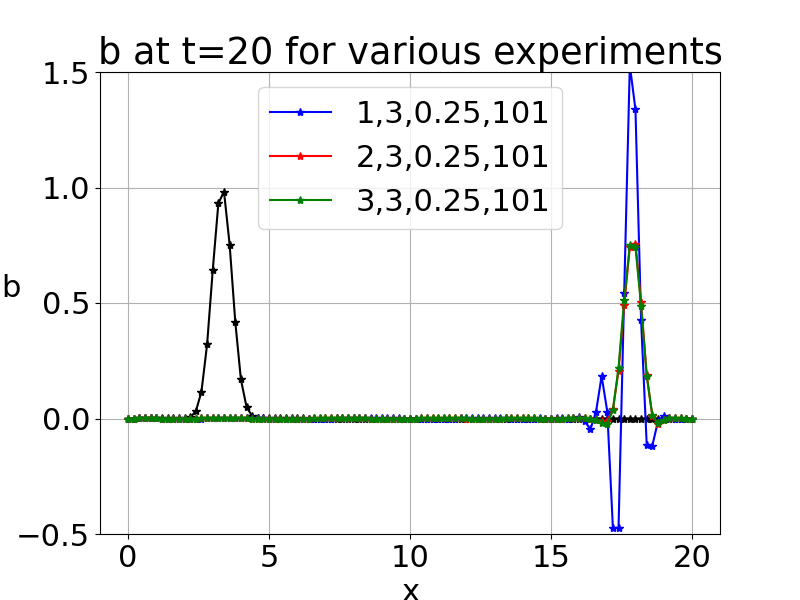

## 4.  Grid resolution

Make a study of 3rd order upwind advection and 3rd Adams-Bashforth, with N=51 N=101 N=201.  Keep the CFL number constant (and use a stable one). Save the image and display it.

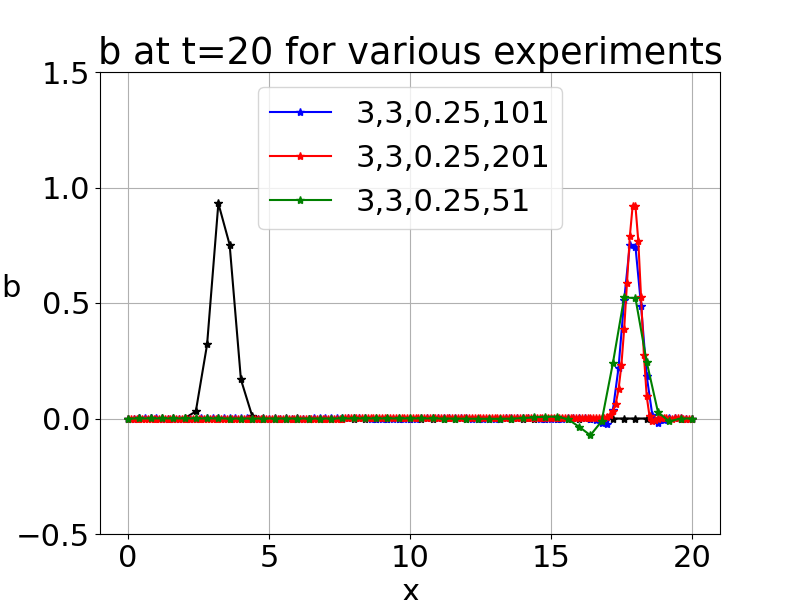